In [1]:
import os
import time
import datetime
from shutil import copyfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xarray as xr
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import copy
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader

In [2]:
BASE_PATH_DATA = 'data/skogsstyrelsen/'
BAND_NAMES = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b11', 'b12']

In [3]:
# Read data + corresponding json info (incl ground truth)
img_paths_train = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_train.npy')))
img_paths_train = [path[1:] for path in img_paths_train]

img_paths_val = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_val.npy')))
img_paths_val = [path[1:] for path in img_paths_val]

img_paths_test = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_names_test.npy')))
img_paths_test = [path[1:] for path in img_paths_test]

json_content_train = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_train.npy'), allow_pickle=True))
json_content_val = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_val.npy'), allow_pickle=True))
json_content_test = list(np.load(os.path.join(BASE_PATH_DATA, 'skogs_json_test.npy'), allow_pickle=True))

train_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_train.npy")))
val_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_val.npy")))
test_label = list(np.load(os.path.join(BASE_PATH_DATA, "skogs_gts_test.npy")))

In [4]:
print(f'train size = {len(img_paths_train)}')
print(f'val size = {len(img_paths_val)}')
print(f'test size = {len(img_paths_test)}')

train size = 260
val size = 72
test size = 100


(0.0, 197.4)

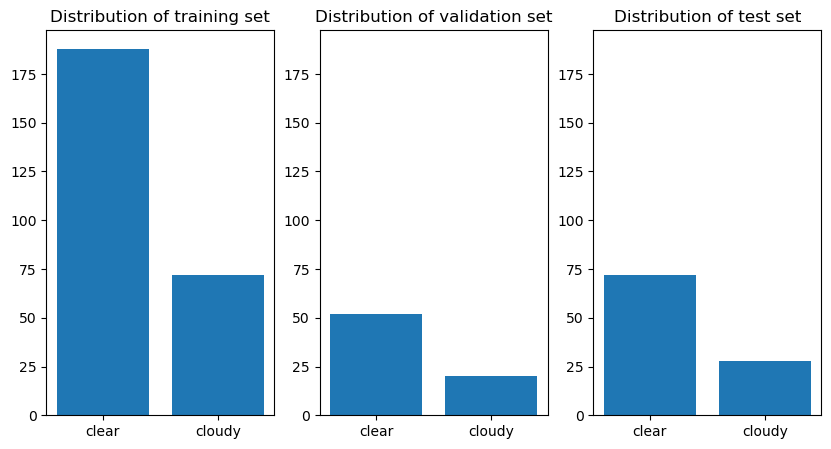

In [5]:
# plot distribution of each data set
labels = ["clear", "cloudy"]
labels_num = [0,1]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

# Bar for training
cloudy = np.count_nonzero(train_label)
clear = len(train_label) - cloudy
ax1.bar(labels_num, [clear,cloudy])
ax1.set_xticks(labels_num, labels)
ax1.set_title("Distribution of training set")
ylim = ax1.get_ylim()

# Bar for validation
cloudy = np.count_nonzero(val_label)
clear = len(val_label) - cloudy
ax2.bar(labels_num, [clear,cloudy])
ax2.set_xticks(labels_num, labels)
ax2.set_title("Distribution of validation set")
ax2.set_ylim(ylim)

# Bar for testing
cloudy = np.count_nonzero(test_label)
clear = len(test_label) - cloudy
ax3.bar(labels_num, [clear,cloudy])
ax3.set_xticks(labels_num, labels)
ax3.set_title("Distribution of test set")
ax3.set_ylim(ylim)


In [6]:
def load_image(path):
    img = xr.open_dataset(path)
    yy_mm_dd = getattr(img, 'time').values[0]
    yy = yy_mm_dd.astype('datetime64[Y]').astype(int) + 1970
    mm = yy_mm_dd.astype('datetime64[M]').astype(int) % 12 + 1

    band_list = []
    for band in BAND_NAMES:
        if yy >= 2022 and mm >= 1: # New normalization after Jan 2022
            band_list.append((getattr(img, band).values - 1000) / 10000)
        else:
            band_list.append(getattr(img, band).values / 10000) 
            
    img = np.concatenate(band_list, axis = 0)
    img = np.transpose(img, [1,2,0])
    img = np.fliplr(img).copy()
    img = np.flipud(img).copy()

    H, W = img.shape[:2]
        
    # padding
    if H != 21 and W != 21:
        zeros = np.zeros((1, 20, 12))
        img = np.concatenate((img, zeros), axis = 0)
        zeros = np.zeros((21, 1, 12))
        img = np.concatenate((img, zeros[:]), axis = 1)
        
    elif H != 21:
        zeros = np.zeros((1, 21, 12))
        img = np.concatenate((img, zeros), axis = 0)
        
    elif W != 21:
        zeros = np.zeros((21, 1, 12))
        img = np.concatenate((img, zeros[:]), axis = 1)
        

    return img

In [7]:
# incase we want to use a Dataloader, we could use this
class CustomImageDataset(Dataset):
    def __init__(self, label_dir, img_dir, transform=None, target_transform=None):
        self.img_labels = list(np.load(label_dir))
        self.img_dir = img_dir
        image_paths = list(np.load(img_dir))
        self.image_paths = [path[1:] for path in image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        
        # convert to float32
        image = np.float32(image)
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
from torch.utils.data import WeightedRandomSampler

BATCH_SIZE = 10
SHUFFLE = False

train_data = CustomImageDataset(os.path.join(BASE_PATH_DATA, "skogs_gts_train.npy"), os.path.join(BASE_PATH_DATA, 'skogs_names_train.npy'), transform=transforms.ToTensor())
labels = train_data.img_labels
class_sample_count = np.array(
    [len(np.where(labels == t)[0]) for t in np.unique(labels)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=SHUFFLE, sampler=sampler)

val_data = CustomImageDataset(os.path.join(BASE_PATH_DATA, "skogs_gts_val.npy"), os.path.join(BASE_PATH_DATA, 'skogs_names_val.npy'), transform=transforms.ToTensor())
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=SHUFFLE)

test_data = CustomImageDataset(os.path.join(BASE_PATH_DATA, "skogs_gts_test.npy"), os.path.join(BASE_PATH_DATA, 'skogs_names_test.npy'), transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=SHUFFLE)

In [9]:
# showing the first batch when using tensors
def show_batch(dl): 
    for images,lables in dl: 
        rgb_img = images[:, [3,2,1], :, :]/torch.max(images[:, [3,2,1], :, :])
        list_img = [img for img in rgb_img]
        Grid = make_grid(list_img, nrow=5)
        img = transforms.ToPILImage()(Grid) 
        img.show() 
        break
        
# show first batch of train data
# show_batch(train_loader)

In [10]:
# train model function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10, show_plot = True):
    
    min_loss = 10000
    
    # Track loss
    training_loss, validation_loss = [], []
    
    # Track accuracy
    training_acc, validation_acc = [], []
    
    for i in range(num_epochs):
        # Track loss
        epoch_training_loss, epoch_validation_loss = 0, 0
        train_size, val_size = 0, 0
        
        # track accuracy
        train_correct, val_correct = 0, 0

        # training
        model.train(True)
        for batch_nr, (data, labels) in enumerate(train_loader):
            # predict
            pred = model(data)
            pred = torch.squeeze(pred)

            # calculate accuracy
            preds = torch.sigmoid(pred) >= 0.5
            
            train_correct += torch.sum(preds==labels).item()
            
            # Clear stored gradient values
            optimizer.zero_grad()
            loss = criterion(pred, labels.float())
            
            # Backpropagate the loss through the network to find the gradients of all parameters
            loss.backward()
            
            # Update the parameters along their gradients
            optimizer.step()
            
            # Update loss
            epoch_training_loss += loss.detach().numpy()
            train_size += len(data)
            
        # validation
        model.eval()
        for batch_nr, (data, labels) in enumerate(val_loader):
            
            # predict
            pred = model(data)
            pred = torch.squeeze(pred)
            
            # calculate accuracy
            preds = torch.sigmoid(pred) >= 0.5
            
            val_correct += torch.sum(preds==labels).item()
             
            # calculate loss
            loss = criterion(pred, labels.float())
            
            # check if loss is smaller than before, if so safe model
            if loss<min_loss:
                torch.save(model, 'best_model.pt')
                min_loss = loss
            
            # Update loss
            epoch_validation_loss += loss.detach().numpy()
            val_size += len(data)
            
        # Save loss for plot
        training_loss.append(epoch_training_loss/train_size)
        validation_loss.append(epoch_validation_loss/val_size)
        
        # Save accuracy for plot
        training_acc.append(train_correct/train_size)
        validation_acc.append(val_correct/val_size)

        # Print loss every 5 epochs
        #if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        print(f'Train accuracy = {train_correct/train_size}')
        print(f'Validation accuracy = {val_correct/val_size}')

        torch.save(model, 'latest_model.pt')
        
    if show_plot:
        # Plot training and validation loss
        epoch = np.arange(len(training_loss))
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_loss, 'r', label='Training loss',)
        plt.plot(epoch, validation_loss, 'b', label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.show()
        
        # Plot training and validation accuracy
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_acc, 'r', label='Training accuracy',)
        plt.plot(epoch, validation_acc, 'b', label='Validation accuracy')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Accuracy')
        plt.show()

Epoch 0, training loss: 0.0027997706945125872, validation loss: 680.3195529513889
Train accuracy = 0.45384615384615384
Validation accuracy = 0.2777777777777778
Epoch 1, training loss: 0.007416691688390879, validation loss: 17191.43576388889
Train accuracy = 0.5192307692307693
Validation accuracy = 0.7222222222222222
Epoch 2, training loss: 0.0037694674271803634, validation loss: 21494.45138888889
Train accuracy = 0.4576923076923077
Validation accuracy = 0.2777777777777778
Epoch 3, training loss: 0.0022345992235037, validation loss: 3530.8611111111113
Train accuracy = 0.6884615384615385
Validation accuracy = 0.2777777777777778
Epoch 4, training loss: 0.0023272812366485597, validation loss: 1458.6178385416667
Train accuracy = 0.7576923076923077
Validation accuracy = 0.2777777777777778
Epoch 5, training loss: 0.0022289257783156173, validation loss: 533.8599717881945
Train accuracy = 0.6884615384615385
Validation accuracy = 0.2777777777777778
Epoch 6, training loss: 0.002132650063588069, v

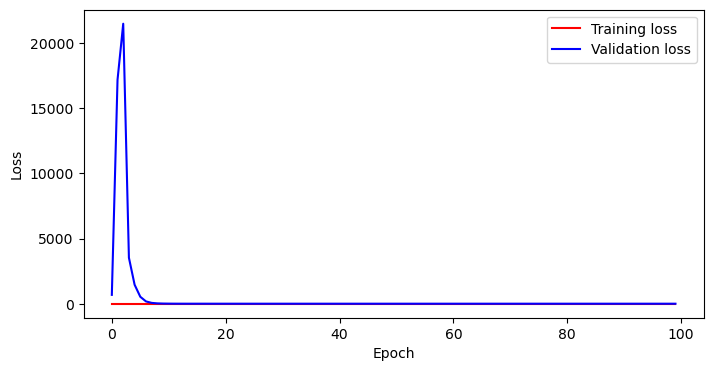

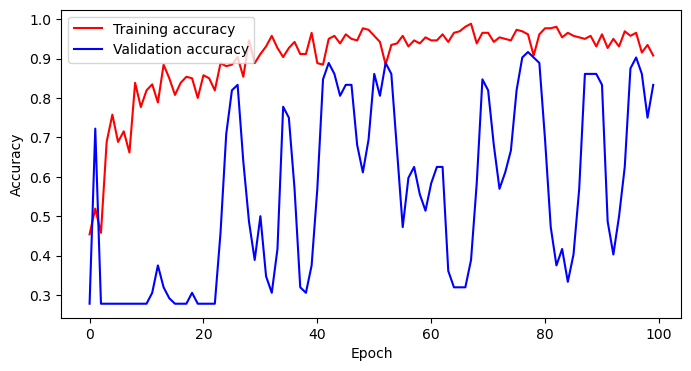

In [11]:
# Hyperparams
LEARNING_RATE = 0.01
EPOCHS = 100

# define network
network = models.resnet18(num_classes = 1)
network.conv1 = nn.Conv2d(12, 64, kernel_size=3, stride=1, padding=5, bias=False) # 12 bands = 12 input channels

# define loss
loss_function = torch.nn.BCEWithLogitsLoss()
# define optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

train_model(network, loss_function, optimizer, train_loader, val_loader, EPOCHS)

Final accuracy: 89.00%
Correct 89 times out of 100
Correct 68 times out of 72: 94.44444444444444
Correct 21 times out of 28: 75.0


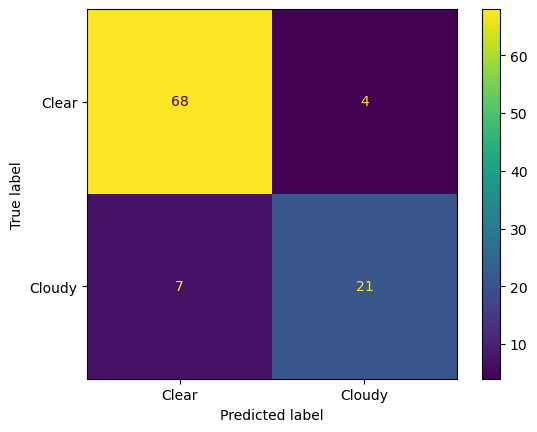

In [12]:
# Testing
correct = 0
predictions = []
cloudy_pred = 0
clear_pred = 0

model = torch.load('best_model.pt')

with torch.no_grad():
    for batch_nr, (data, labels) in enumerate(test_loader):
        
            # predict
            pred = model(data)
            pred = torch.squeeze(pred)
        
            # calculate accuracy
            preds = torch.sigmoid(pred) >= 0.5
            
            for pred in preds:
                predictions.append(pred)

for idx, pred in enumerate(predictions):
    if pred == test_label[idx]:
        correct += 1
        if pred == 1:
            cloudy_pred += 1
        else:
            clear_pred += 1

print("Final accuracy: %.2f%%" % (100*correct/len(test_label)))
print(f'Correct {correct} times out of {len(img_paths_test)}')


total_cloudy = np.sum(test_label)
total_clear = len(test_label)-total_cloudy

print(f'Correct {clear_pred} times out of {total_clear}: {100*clear_pred/total_clear}')
print(f'Correct {cloudy_pred} times out of {total_cloudy}: {100*cloudy_pred/total_cloudy}')

cm = confusion_matrix(test_label, predictions)
ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=['Clear', 'Cloudy']).plot()